<h1>Cascade Cup 2020 submission for round 2 (datathon)</h1>

Team Name: **ML Hacksters**

Member 1: **Nippun Sharma (inbox.nippun@gmail.com)**

Member 2: **Naveen Saisreenivas Thota (naveensaisreenivas@gmail.com)**

Public Leaderboard Score: *80.89416646619021*


**Preprocessing Techniques**:


1.   `RobustScaler` (`sklearn.preprocessing`)
2.   `StandardScaler` (`sklearn.preprocessing`)

**Feature engineering**:


1.   `PolynomialFeatures` (`sklearn.preprocessing`)
2.   `FeatureAgglomeration` (`sklearn.cluster`)


**Models Used**: 

1.   `HistGradientBoostingClassifier` (`sklearn.ensemble`)
2.   `AdaBoostClassifier` (`sklearn.ensemble`)

> For ease of underastanding and keeping the notebook clean we have used    `sklearn.pipeline.Pipeline`


> For making the model more general we are using `Out of Fold` prediction technique (num folds = 5). 


> To combine the predictions for each pipeline we are using the mean of each component of the 5 which are trained on 5 different folds of data.

> Finally, we are taking the weighted mean (weights: 0.9 and 0.1 respectively) of both the pipes.

<h1>EDA</h1>

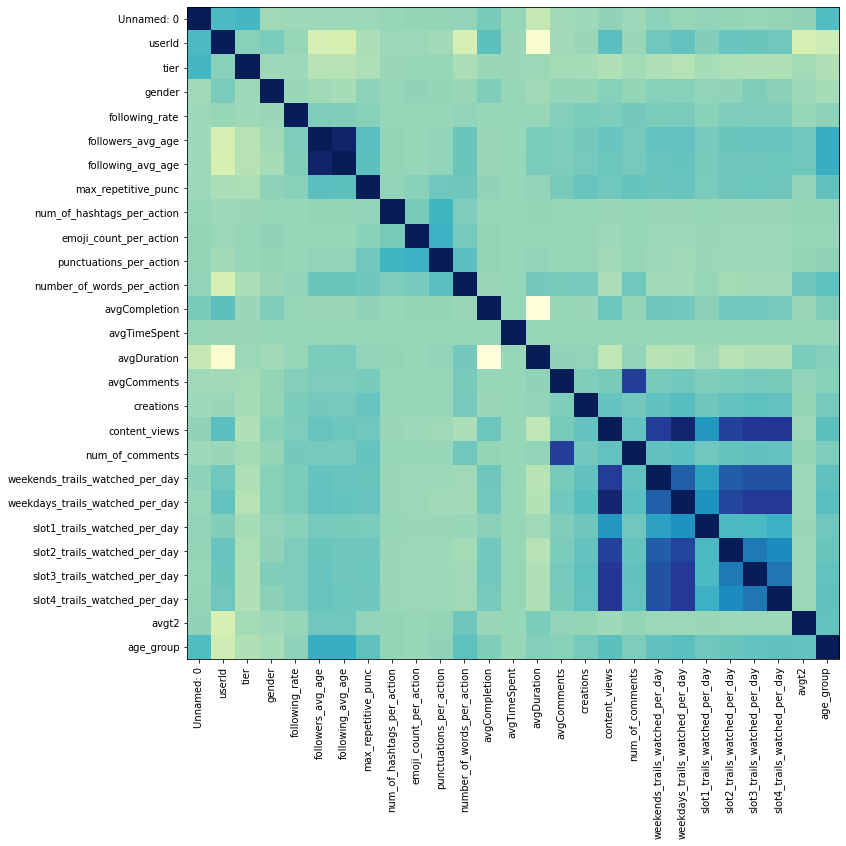

In [10]:
# Importing necessary functions and libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# change the path of files accordingly.
train_data = pd.read_csv("train_age_dataset.csv")
test_data = pd.read_csv("test_age_dataset.csv")
sample = pd.read_csv("sample_submission.csv")

#Pearson Correlation between all the features
corr=train_data.corr()
fig,ax=plt.subplots(figsize=(12,12))
ax.imshow(corr, cmap="YlGnBu")
plt.xticks(range(len(corr)),corr.columns,rotation=90)
plt.yticks(range(len(corr)),corr.index)
plt.show()

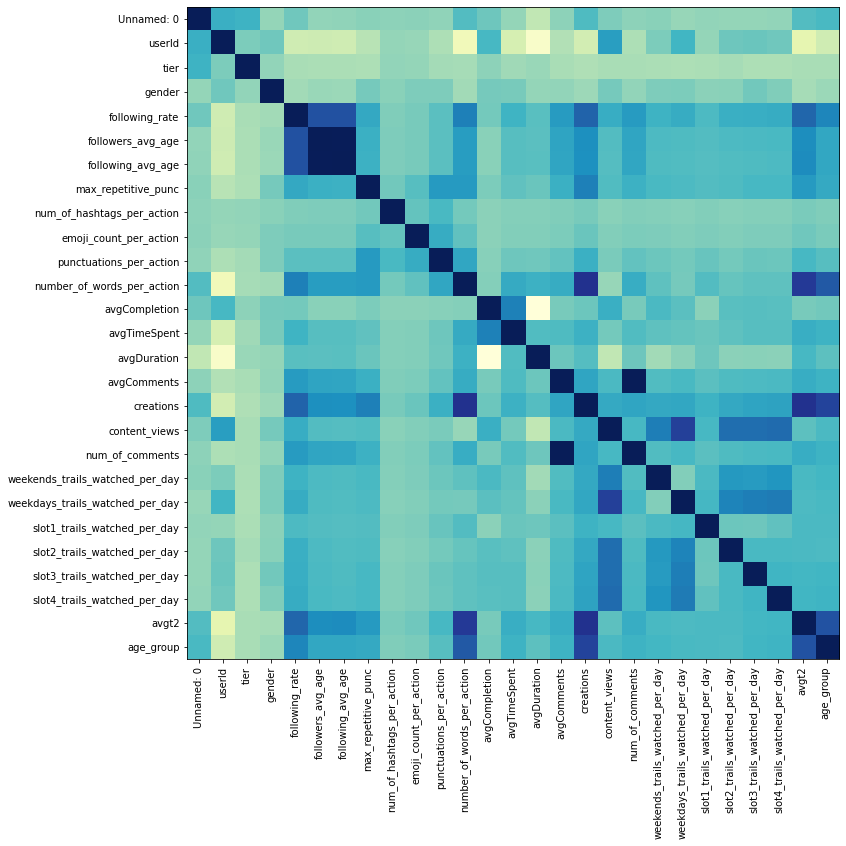

In [11]:
#Spearman Correlation between all the features
corr=train_data.corr(method='spearman')
fig,ax=plt.subplots(figsize=(12,12))
ax.imshow(corr, cmap="YlGnBu")
plt.xticks(range(len(corr)),corr.columns,rotation=90)
plt.yticks(range(len(corr)),corr.index)
plt.show()

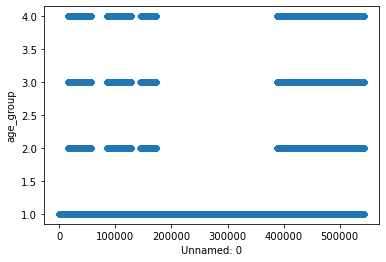

In [12]:
# Relationship between age_group and Unnamed:0
train_sort = train_data.sort_values('Unnamed: 0')
train_sort.plot(kind='scatter', x='Unnamed: 0', y='age_group')
plt.show()

Clearly, there is a relationship between `Unnamed: 0`  and `age_group`, and hence, we haven't dropped it while fitting the model. <br>
Examining it further, we realized that for all values of `Unnamed: 0` in the given ranges, the `age_group` was always 1 - 

<li> 0 to 15627 </li>
<li> 57224 to 84236 </li>
<li> 127821 to 144676 </li>
<li> 171714 to 388230 </li>

<h1>Model Fitting</h1>

In [13]:
# Importing necessary functions and libraries

from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import RobustScaler, StandardScaler, PolynomialFeatures
from sklearn.cluster import FeatureAgglomeration

# creating framework of pipeline 1
pipe_1_frame = Pipeline([('rs', RobustScaler(quantile_range=(0.2282, 0.7468))),
                   ('adaboost', AdaBoostClassifier(
                                                   learning_rate=0.228022,
                                                   base_estimator=DecisionTreeClassifier(max_depth=6),
                                                   n_estimators=284,
                                                   random_state=2019))
                   ])

# creating framework of pipeline 2
pipe_2_frame = Pipeline([('ss', StandardScaler()),
                   ('pf', PolynomialFeatures(degree=2)),
                   ('fa', FeatureAgglomeration(affinity='manhattan',
                                               linkage='complete',
                                               n_clusters=78,
                                               pooling_func=np.mean)),
                   ('histgradientboost', HistGradientBoostingClassifier(
                                                                        l2_regularization=0.26386,
                                                                        learning_rate=0.0223608,
                                                                        max_leaf_nodes=171,
                                                                        min_samples_leaf=6,
                                                                        n_iter_no_change=19,
                                                                        validation_fraction=0.016209,
                                                                        random_state=2019))
                   ])

In [14]:
# separating dependent and independent variables for train data
x_train = train_data.drop("age_group", 1).values
y_train = train_data["age_group"].values

# test data
x_test = test_data.values

In [ ]:
# Importing necessary functions and libraries

from sklearn.model_selection import KFold # for out of fold prediction
from sklearn.base import clone # for creating copies
import joblib # for saving trained pipes
import os

# creating directories to save trained pipelines.
dir_1 = "pipe_1/"
dir_2 = "pipe_2/"

os.mkdir(dir_1)
os.mkdir(dir_2)

NUM_FOLDS = 5
kf = KFold(n_splits=NUM_FOLDS)

# training and saving pipelines for each fold.
for idx, (train_idx, test_idx) in enumerate(kf.split(x_train, y_train)):
  print("Training on fold {}".format(idx + 1))

  temp_1 = clone(pipe_1_frame)
  temp_2 = clone(pipe_2_frame)

  temp_1.fit(x_train[train_idx, :], y_train[train_idx])
  print("Pipe 1 trained...")
  temp_2.fit(x_train[train_idx, :], y_train[train_idx])
  print("Pipe 2 trained...")

  # storing the pipeline on disk.
  joblib.dump(temp_1, "pipe_1/" + str(idx+1) + ".pkl")
  joblib.dump(temp_2, "pipe_2/" + str(idx+1) + ".pkl")

In [ ]:
# making predictions on test data.

# lists for storing probabilities on test data for each fold.
preds_1 = []
preds_2 = []

for idx in range(1,6):
  # loading the pipelines from disk.
  temp_1 = joblib.load(dir_1 + str(idx) + ".pkl")
  temp_2 = joblib.load(dir_2 + str(idx) + ".pkl")

  preds_1.append(temp_1.predict_proba(x_test))
  preds_2.append(temp_2.predict_proba(x_test))

# converting to numpy arrays
preds_1 = np.array(preds_1)
preds_2 = np.array(preds_2)

In [ ]:
# combining probabilities of each fold by taking mean of all.
preds_1 = np.mean(preds_1, axis=0)
preds_2 = np.mean(preds_2, axis=0)

In [ ]:
# weigthed mean of probabilites from the two pipeline frameworks.
preds = preds_1 * 0.9 + preds_2 * 0.1

# getting classes from final probabilites (hard classification from soft classification). 
preds = np.argmax(preds, axis=1) + 1

In [ ]:
# creating submission file
sample['prediction'] = np.ravel(preds)
sample.to_csv("final_submission.csv", index=False)